# **Лабораторная работа 3**

В данном блокноте представлено совместое выполнение Лабораторной 3 Надери Мариам и Миляева Дмитрия.

# **Часть 1**

# Постановка задания:

Выберите одну любую из задач, рассмотренных на лекции (локализация, сегментация, перенос стиля, генерация).

Подберите на kaggle датасет, подходящий для решения этой задачи.

Вариант 1: если данные обладают необходимой разметкой, то повторите пайплайн из блокнота с примером на своих данных.
Вариант 2: если данные не обладают необходимой разметкой, то используйте модель, которую дообучали в примере, но без дообучения.
Оцените и прокомментируйте результат.

# Реализуемая задача:

Перенос стиля

In [ ]:
!pip install torch torchvision
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 19 (delta 2), reused 1 (delta 1), pack-reused 16 (from 1)
Receiving objects: 100% (19/19), 3.30 MiB | 7.46 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torchvision import models
from PIL import Image
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
vgg = models.vgg19(pretrained=True)
vgg = vgg.features


for parameters in vgg.parameters():
  parameters.requires_grad_(False)

dev = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(dev)
vgg.to(dev)


'''Предобработка изображений'''


def preprocess(img_path, max_size=500):
    image = Image.open(img_path).convert("RGB")
    size = max_size if max(image.size) > max_size else max(image.size)
    img_transforms = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    image = img_transforms(image)
    image = image.unsqueeze(0)
    return image

content_image_path = "/content/Кот.jpg"
style_image_path = "/content/радуга.png"

content_preprocess = preprocess(content_image_path)
style_preprocess = preprocess(style_image_path)

content_preprocess = content_preprocess.to(dev)
style_preprocess = style_preprocess.to(dev)

print(f"Content shape: {content_preprocess.shape}")
print(f"Style shape: {style_preprocess.shape}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 63.0MB/s]


cuda
Content shape: torch.Size([1, 3, 699, 500])
Style shape: torch.Size([1, 3, 500, 749])


# Преобразование вектора в картинку

In [ ]:
'''Преобразование вектора в картинку'''


def deprocess(tensor):
  image = tensor.to("cpu").clone()
  image = image.numpy()
  image = image.squeeze(0)
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.485, 0.456, 0.406]) + np.array([0.229, 0.224, 0.225])
  image = image.clip(0,1)

  return image
content_deproc = deprocess(content_preprocess)
style_deproc = deprocess(style_preprocess)

print(f"Deprocess content: {content_deproc.shape}")
print(f"Deprocess style: {style_deproc.shape}")


Deprocess content: (699, 500, 3)
Deprocess style: (500, 749, 3)


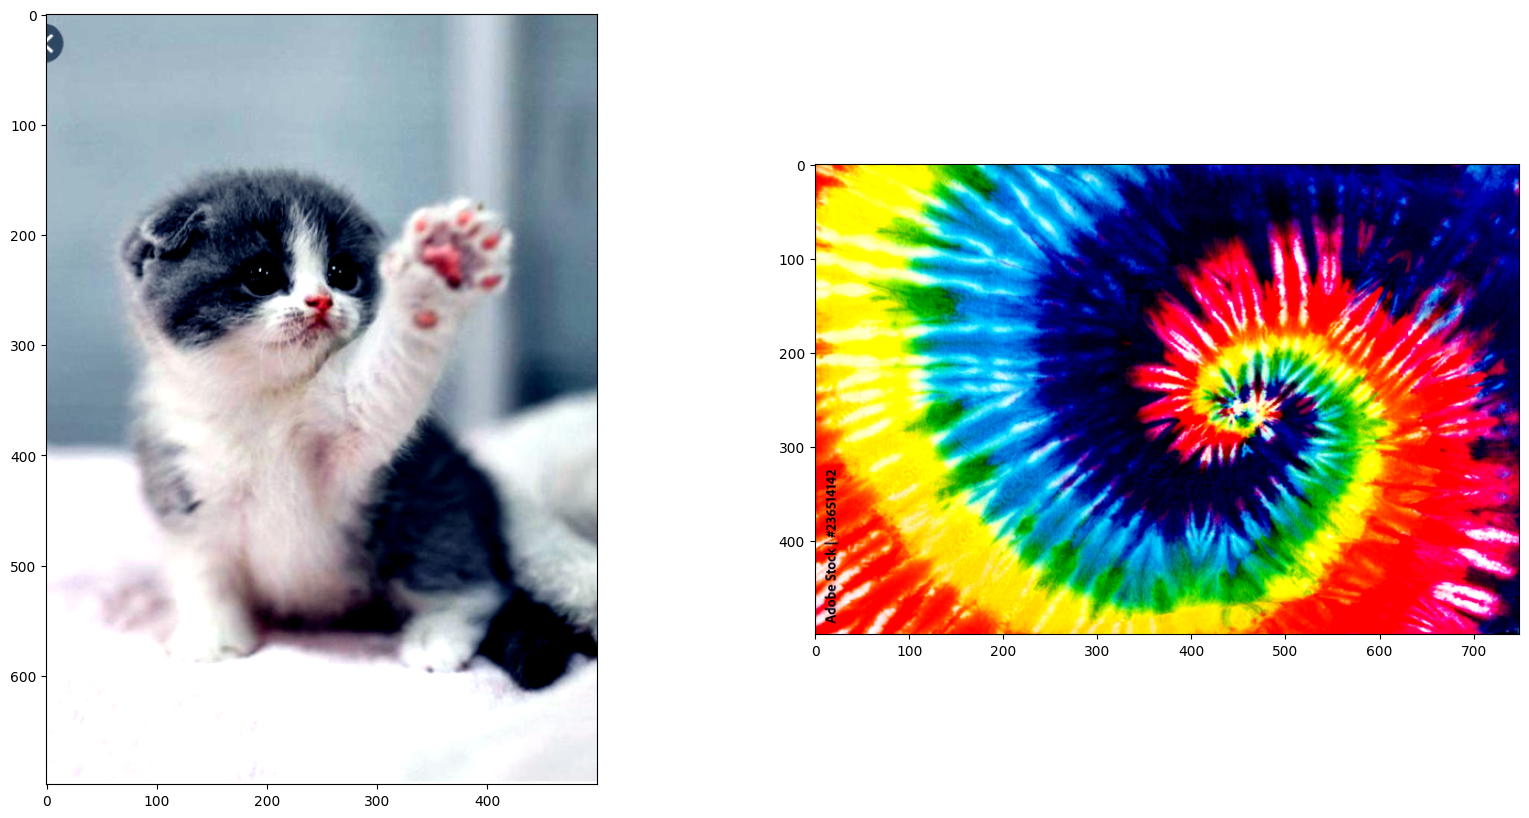

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(content_deproc)
ax2.imshow(style_deproc);

# Извлечение признаков. Функция потерь

In [ ]:
'''Извлечение признаков из картинки и стиля, построение матрицы Грама'''
def get_features(image, model):
  layers = {
      "0": "conv1_1",
      "5": "conv2_1",
      "10": "conv3_1",
      "19": "conv4_1",
      "21": "conv4_2",
      "28": "conv5_1"
  }

  x = image
  Features = {}
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      Features[layers[name]] = x

  return Features

content_features = get_features(content_preprocess, vgg)
style_features = get_features(style_preprocess, vgg)

def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}



''' Создание функций потерь для картинки и стиля '''
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

style_weights = {
    "conv1_1": 1.0,
    "conv2_1": 0.75,
    "conv3_1": 0.75,
    "conv4_1": 0.75,
    "conv5_1": 0.75
}

def style_loss(style_weights, target_fs, style_grams):
  loss = 0
  for layer in style_weights:
    target_feature = target_fs[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    b, c, h, w = target_feature.shape
    layer_loss = style_weights[layer]*torch.mean((target_gram-style_gram)**2)
    loss += layer_loss/(c*h*w)

  return loss

target = content_preprocess.clone().requires_grad_(True).to(dev)


target_f = get_features(target,vgg)
print(f"Content loss: {content_loss(target_f['conv4_2'], content_features['conv4_2'])}")
print(f"Style loss: {style_loss(style_weights, target_f,style_grams)}")

Content loss: 0.0
Style loss: 2615.039794921875


# Оптимизация изображения

In [ ]:
from torch import optim

optimizer = optim.Adam([target],lr=0.003)
alpha = 1.0
beta = 1e5
epochs = 4000
show_every = 500

def total_loss(c_loss, s_loss, alpha, beta):
  loss = alpha*c_loss + beta*s_loss
  return loss

results = []
for i in range(epochs):
  target_f = get_features(target,vgg)
  c_loss = content_loss(target_f["conv4_2"], content_features["conv4_2"])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss,s_loss, alpha, beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print(f"Total loss at Epoch {i}: {t_loss}")
    results.append(deprocess(target.detach()))

Total loss at Epoch 0: 261503984.0
Total loss at Epoch 500: 51750688.0
Total loss at Epoch 1000: 21907890.0
Total loss at Epoch 1500: 11607751.0
Total loss at Epoch 2000: 4834330.0
Total loss at Epoch 2500: 1936460.25
Total loss at Epoch 3000: 983576.6875
Total loss at Epoch 3500: 612397.75


# Демонстрация этапов

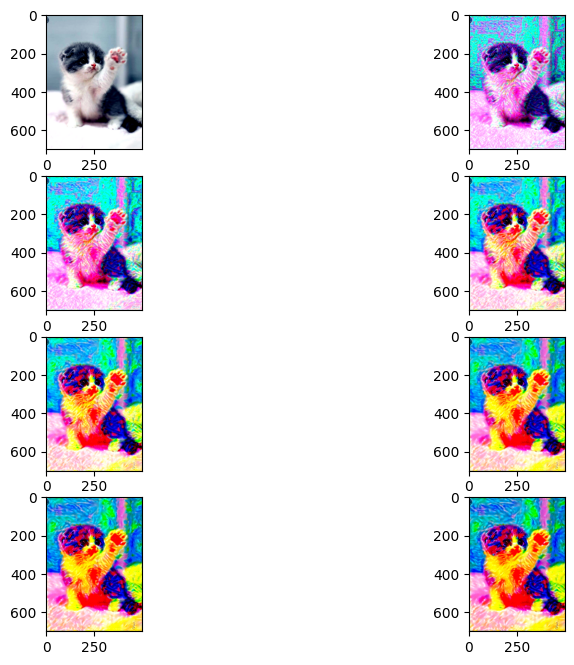

In [ ]:
plt.figure(figsize=(10,8))
for i,_ in enumerate(results):
  plt.subplot(4,2, i+1)
  plt.imshow(results[i])
plt.show()

# Демонстрация результата

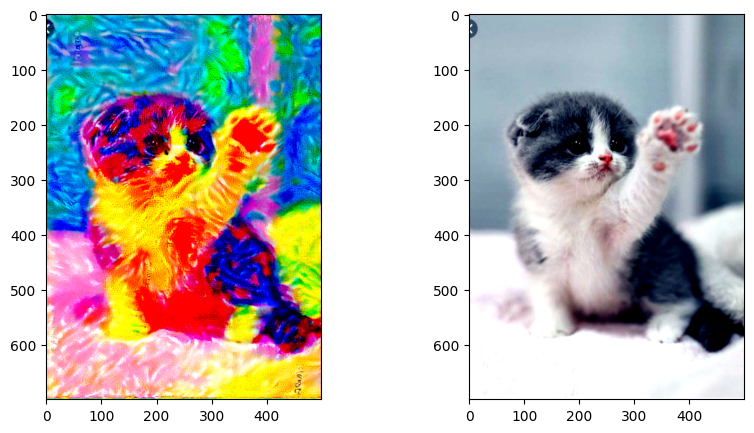

In [ ]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_preprocess)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy);

# Выводы

На полученном изображении прослеживаются черты переносимого стиля: радужные цвета, а также светлые прожилки. Кроме того, в правом нижнем углу можно разглядеть нечто вроде текста. Речь о черных "загагулинах". Они получились ввиду наличия на стилевом изображении вертикальной надписи в левом нижнем углу.